In [1]:
import xml.etree.ElementTree as ET
import operator
import logging
from typing import Any, Dict, List, Tuple, TypedDict, Annotated
import pandas as pd
import pygraphviz as pgv
from langchain_ollama.llms import OllamaLLM
from langchain.prompts import PromptTemplate
from langchain.schema.runnable import RunnableSequence
from langgraph.graph import StateGraph

In [2]:
pentaho_file_path = '../data/benef_transf.ktr'

In [3]:
import xml.etree.ElementTree as ET
import operator
import logging
from typing import Any, Dict, List, Tuple, TypedDict, Annotated
import pandas as pd
import pygraphviz as pgv
from langchain_ollama.llms import OllamaLLM
from langchain.prompts import PromptTemplate
from langchain.schema.runnable import RunnableSequence
from langgraph.graph import StateGraph

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class AgentState(TypedDict):
    messages: Annotated[list[Any], operator.add]
    file_path: str
    root: ET.Element
    sequence: List[Tuple[str, str]]
    queries: List[Dict[str, str]]
    relations: pd.DataFrame
    documentation: str

class Agent:
    def __init__(self, model: Any, tools: Any, file_path: str, system: str = "", max_tokens_per_part: int = 400):
        self.system = system
        self.file_path = file_path
        self.llm = model
        self.max_tokens_per_part = max_tokens_per_part
        self.graph = self._create_state_graph()

    def _create_state_graph(self) -> StateGraph:
        graph = StateGraph(AgentState)
        
        graph.add_node("parse", self.parse_ktr_file)
        graph.add_node("extract_sequence", self.extract_execution_sequence)
        graph.add_node("extract_sql", self.extract_sql_queries)
        graph.add_node("extract_relations", self.extract_table_column_relations_llm)
        graph.add_node("create_documentation", self.create_documentation)
        graph.add_node("create_graph", self.create_execution_graph)

        graph.add_edge("parse", "extract_sequence")
        graph.add_edge("extract_sequence", "extract_sql")
        graph.add_edge("extract_sql", "extract_relations")
        graph.add_edge("extract_relations", "create_documentation")
        graph.add_edge("create_documentation", "create_graph")
        
        graph.set_entry_point("parse")
        return graph.compile()

    def parse_ktr_file(self, state: AgentState) -> AgentState:
        try:
            tree = ET.parse(state["file_path"])
            state["root"] = tree.getroot()
        except ET.ParseError as e:
            logging.error(f"Error parsing KTR file: {e}")
            raise
        return state

    def extract_execution_sequence(self, state: AgentState) -> AgentState:
        hops = []
        for hop in state["root"].findall('.//hop'):
            from_step = hop.find('from').text
            to_step = hop.find('to').text
            enabled = hop.find('enabled').text
            if enabled == 'Y':
                hops.append((from_step, to_step))
        
        state["sequence"] = hops
        return state    

    def extract_sql_queries(self, state: AgentState) -> AgentState:
        active_steps = set(step for seq in state["sequence"] for step in seq)
        sql_steps = state["root"].findall(".//step")
        queries = []
        
        for step in sql_steps:
            step_name = step.find("name").text
            step_type = step.find("type").text
            if step_type in ['TableInput', 'DBJoin'] and step_name in active_steps:
                sql_element = step.find("sql")
                if sql_element is not None and sql_element.text:
                    queries.append({
                        "step_name": step_name,
                        "step_type": step_type,
                        "sql": sql_element.text
                    })
        
        state["queries"] = queries
        return state

    def extract_table_column_relations_llm(self, state: AgentState) -> AgentState:
        df = self._extract_table_column_relations_llm(self.llm, state["queries"])
        state["relations"] = df
        return state
          

    def _extract_table_column_relations_llm(self, llm: Any, queries: List[Dict[str, str]]) -> pd.DataFrame:

        def _get_response_text(response: Any) -> str:
            if isinstance(response, str):
                return response
            elif hasattr(response, 'content'):
                return response.content
            elif hasattr(response, 'text'):
                return response.text
            else:
                return ""  

        prompt_template = PromptTemplate(
            input_variables=["sql"],
            template="""
            Analyze the following SQL query and extract all the table/column relationships, ensuring that the original table names are captured, even if aliases (nicknames) are used:
            {sql}
            Return a list of table/column pairs in the format:
            original_table_name,column_name
            original_table_name,column_name
            ...
            Do not include any additional text in your response, only the list of pairs.
            """
        )

        chain = RunnableSequence(
            prompt_template,
            llm
        )

        results = []

        for query in queries:
            sql_code = query['sql']
            sql_parts = self._split_sql_code(sql_code)

            for sql_part in sql_parts:
                try:
                    response = chain.invoke({"sql": sql_part})
                    response_text = _get_response_text(response)
                    lines = response_text.strip().split('\n')

                    for line in lines:
                        if ',' in line:
                            parts = line.split(',')
                            if len(parts) == 2:
                                table, column = parts
                                results.append({'nome_tabela': table.strip(), 'nome_coluna': column.strip()})
                            else:
                                logging.warning(f"Unexpected format: {line}")
                except Exception as e:
                    logging.error(f"Error processing SQL part: {e}")

        df = pd.DataFrame(results).drop_duplicates()
        return df

    def _split_sql_code(self, sql_code: str) -> List[str]:
        sql_lines = sql_code.split('\n')
        parts = []
        current_part = []
        current_length = 0

        for line in sql_lines:
            line_length = len(line.split())
            if current_length + line_length > self.max_tokens_per_part:
                parts.append('\n'.join(current_part))
                current_part = [line]
                current_length = line_length
            else:
                current_part.append(line)
                current_length += line_length

        if current_part:
            parts.append('\n'.join(current_part))

        return parts

    def create_documentation(self, state: AgentState) -> AgentState:
        """Creates Markdown documentation summarizing the KTR pipeline."""
        doc_lines = ["# Pipeline Documentation\n"]

        doc_lines.append("## Execution Sequence\n")
        for idx, (from_step, to_step) in enumerate(state["sequence"], start=1):
            doc_lines.append(f"{idx}. {from_step} -> {to_step}\n")

        doc_lines.append("## Steps and SQL Summaries\n")
        for query in state["queries"]:
            doc_lines.append(f"### Step: {query['step_name']}\n")
            doc_lines.append(f"- Type: {query['step_type']}\n")
            doc_lines.append("#### SQL Summary:\n")
            doc_lines.append(f"```sql\n{query['sql'][:200]}...\n```\n")

        doc_lines.append("## Table/Column Relationships\n")
        for _, row in state["relations"].iterrows():
            doc_lines.append(f"- {row['nome_tabela']} -> {row['nome_coluna']}\n")

        state["documentation"] = "\n".join(doc_lines)
        return state

    def create_execution_graph(self, state: AgentState) -> AgentState:
        self.create_flow_graph(state["sequence"])
        return state

    def create_flow_graph(self, hops: List[Tuple[str, str]], output_file: str = "flow_graph.png"):
        graph = pgv.AGraph(directed=True)
        
        for from_step, to_step in hops:
            graph.add_node(from_step, shape="box")
            graph.add_node(to_step, shape="box")
            graph.add_edge(from_step, to_step)
        
        graph.layout(prog='dot')
        graph.draw(output_file)
        logging.info(f"Data flow saved in {output_file}")

    def run(self) -> AgentState:
        initial_state = AgentState(
            messages=[],
            file_path=self.file_path,
            root=None,
            sequence=[],
            queries=[],
            relations=pd.DataFrame(),
            documentation=""
        )
        try:
            final_state = self.graph.invoke(initial_state)
            return final_state
        except Exception as e:
            logging.error(f"Error running agent pipeline: {e}")
            raise

In [181]:
model = OllamaLLM(model='qwen2:latest', temperature=0.0)

In [182]:
# model = ChatGoogleGenerativeAI(
#     model='gemini-1.5-pro-exp-0801',
#     temperature=0
# )

In [183]:
tool = []

In [184]:
prompt = ""

In [185]:
abot = Agent(model=model, tools=None, file_path=pentaho_file_path)

In [186]:
abot.run()

2024-08-23 20:45:53,439 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2024-08-23 20:46:23,107 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2024-08-23 20:46:54,131 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2024-08-23 20:47:28,936 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2024-08-23 20:48:20,581 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2024-08-23 20:48:26,515 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2024-08-23 20:49:15,092 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2024-08-23 20:49:28,573 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2024-08-23 20:49:42,381 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2024-08-23 20:49:59,654 - INFO - HTTP Request:

{'messages': [],
 'file_path': '../data/benef_transf.ktr',
 'root': <Element 'transformation' at 0x7632745b12b0>,
 'sequence': [('Switch / Case LOCAL FATURAMENTO',
   'Switch / Case TITULAR RESPONSÁVEL'),
  ('Switch / Case PESSOA RESPONSÁVEL', 'Dummy (do nothing) 2'),
  ('Switch / Case PESSOA RESPONSÁVEL', 'FAMILIA PESSOA RESPONSÁVEL'),
  ('Switch / Case TITULAR RESPONSÁVEL', 'FAMILIA TITULAR RESPONSÁVEL'),
  ('Switch / Case TITULAR RESPONSÁVEL', 'Switch / Case PESSOA RESPONSÁVEL'),
  ('Dummy (do nothing)', 'Remover colunas'),
  ('Remover colunas', 'Switch / Case LOCAL FATURAMENTO'),
  ('BENEFICIÁRIO', 'SAM_FAMILIA_TETO_PF'),
  ('SAM_FAMILIA_TETO_PF', 'Dummy (do nothing)'),
  ('SEM SETOR', 'Insert / Update - BN_BENEFICIARIO'),
  ('Insert / Update - BN_BENEFICIARIO', 'QTD_INCATU_BN_BENEFICIARIO'),
  ('Filter rows', 'BUSCA MICROSIGA'),
  ('BUSCA MICROSIGA', 'Insert / Update - BN_BENEFICIARIO'),
  ('HANDLE_BENEFICIARIO', 'BENEFICIÁRIO'),
  ('Filter rows', 'SEM SETOR'),
  ('Blocking Step',

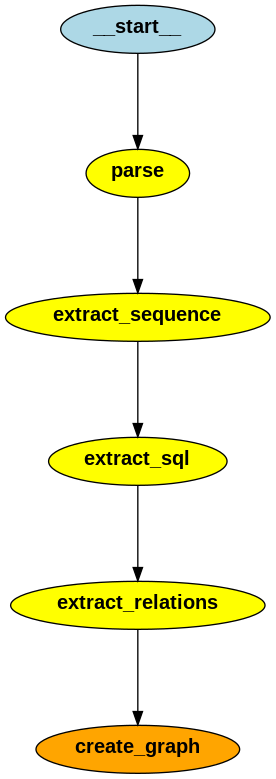

In [141]:
from IPython.display import Image
Image(abot.graph.get_graph().draw_png())